In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
#%%script false

# import fastai
# fastai.show_install(0)



```text
=== Software === 
python version  : 3.7.0
fastai version  : 1.0.34
torch version   : 1.0.0.dev20181120
nvidia driver   : 410.72
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7401
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 7611MB | Tesla P4

=== Environment === 
platform        : Linux-4.9.0-8-amd64-x86_64-with-debian-9.6
distro          : #1 SMP Debian 4.9.130-2 (2018-10-27)
conda env       : base
python          : /opt/anaconda3/bin/python
sys.path        : 
/home/jupyter/tutorials/fastai/course-v3/nbs/dl1
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s

In [3]:
path=Path("/home/jupyter/tutorials/data/fake_or_real_news")
#path.ls()

[PosixPath('/home/jupyter/tutorials/data/fake_or_real_news/fake_or_real_news.csv')]

Had to use a Pandas df and rearrange/drop cols to avoid a weird TypeError when reading the full csv file

In [4]:
df = pd.read_csv(path/'fake_or_real_news.csv', usecols=["label", "text"])[["label", "text"]]

In [22]:
df.head()

,label,text
0,FAKE,"Daniel Greenfield, a Shillman Journalism Fello..."
1,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,REAL,U.S. Secretary of State John F. Kerry said Mon...
3,FAKE,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,REAL,It's primary day in New York and front-runners...


In [10]:
data.show_batch()

text,target
"xxbos xxmaj why xxmaj are xxmaj so xxmaj many xxmaj people xxmaj choosing xxmaj to xxmaj leave xxmaj the xxmaj united xxmaj states xxmaj permanently ? xxmaj august 11th , 2013 \n xxmaj have things gotten so bad that it is time to leave the xxmaj united xxmaj states for good ? xxmaj that is a question that a lot of xxmaj americans are dealing with these days , and",FAKE
"xxbos in xxmaj communal xxmaj harmony — by xxmaj xxunk xxmaj xxunk — xxmaj november 5 , 2016 \n xxmaj on xxmaj monday the 31st of xxmaj october 2016 the xxmaj xxunk xxmaj pradesh police assassinated eight alleged associates of the xxmaj students’ xxmaj islamic xxmaj movement of xxmaj india ( xxup simi ) after an alleged escape from prison near xxmaj bhopal . xxmaj this was not coincidentally a",FAKE
"xxbos xxmaj the elites in xxmaj washington almost uniformly believe xxmaj hillary xxmaj clinton will be elected president in xxmaj november . xxmaj the conventional wisdom underlying coverage of 2016 is that xxmaj donald xxmaj trump will go down in flames and probably take the xxmaj republican xxmaj senate with him . \n\n xxmaj the presumptive xxup gop nominee has a well - documented history of misogyny , xenophobia and",REAL
"xxbos xxup the xxup big xxup idea : xxmaj shaking up his campaign once again , xxmaj donald xxmaj trump has decided to let xxmaj trump be xxmaj trump . \n\n xxmaj the xxmaj republican nominee knows he ’s losing . xxmaj xxunk unable to take personal responsibility , he blames his slide in the polls on the people who have prodded him to act “ presidential ” and",REAL
"xxbos ( xxup cnn ) xxmaj this story was reported by xxmaj dana xxmaj bash , xxmaj gloria xxmaj borger , xxmaj abigail xxmaj xxunk , xxmaj jeremy xxmaj diamond , xxmaj chris xxmaj xxunk , xxmaj noah xxmaj gray , xxmaj ashley xxmaj xxunk , xxmaj xxunk xxmaj klein , xxmaj elizabeth xxmaj landers , xxmaj phil xxmaj xxunk , xxmaj dan xxmaj merica , xxmaj sara xxmaj murray",REAL


# Building the language model

Had to drop batch size to avoid cuda memory error

In [5]:
bs=32

Read cols as a list to avoid other strange errors - fix suggested by Francisco Ingham - thanks!

In [6]:
data_lm = (TextList.from_df(df, cols=['text','label'])
                .random_split_by_pct(0.2)
                .label_for_lm()
                .databunch(bs=bs))

In [7]:
data_lm.save('tmp_lm')

In [9]:
data_lm.show_batch(5)

idx,text
0,"xxbos xxmaj xxunk , xxmaj maryland ( xxup cnn ) xxmaj president xxmaj barack xxmaj obama , facing xxmaj persian xxmaj gulf countries deeply skeptical about his proposed nuclear deal with xxmaj iran , said xxmaj thursday that the xxup u.s. would use military force if necessary to defend its xxmaj arab allies . \n\n xxmaj obama had spent the day huddled with leaders from the region at his xxmaj"
1,"- threatening medical problem . \n xxmaj get in xxmaj shape \n xxmaj this one goes hand - in - hand with eating healthy . xxmaj people who are in good physical condition are much less likely to have medical problems , especially high blood pressure , diabetes and high cholesterol ; all of which can become life - threatening . \n xxmaj however , there ’s another part to"
2,". \n\n xxmaj instead , they are the words of xxmaj xxunk , a 19th century master magician in the fictional film , “ xxmaj the xxmaj xxunk . ” xxmaj and , just like xxmaj obama , he uses his abilities to fool the masses into believing that his xxunk are quite real . \n\n xxmaj the president sold his health care plan on the promise that it would"
3,"it would take for lawsuits for damages to make their way through the judicial system . xxmaj that makes their representation about xxup u.s. assets look a bit less like a threat than an expression of defensive strategy . \n\n xxmaj regardless of the xxmaj saudi threat , the xxmaj obama administration ’s resistance to this bill makes a bit more sense . \n\n xxmaj what ’s interesting about"
4,"own borders . \n xxmaj americans raised on a pervasive ideology of “ exceptionalism ” all too easily assume that our far - flung military presence is simply the natural order of things , and that any challenge to it must be countered . a little reflection , however , should suggest why countries — like xxmaj russia , xxmaj china and xxmaj iran — grow hostile and even paranoid"


The text is generally fairly long, several thousand chars

In [17]:
df['text'][1]

'Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it. \nIn a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @SpeakerRyan says he voted for @realDonaldTrump : “Republicans, it is time to come home” ht

In [25]:
df.iloc[1000:1005]['text'].str.len()

1000    2660
1001    2903
1002    4015
1003    6389
1004    3062
Name: text, dtype: int64

In [10]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'to',
 'of',
 'and',
 'a',
 'in',
 'that',
 '\n\n',
 'is',
 'for']

In [19]:
np.shape(data.train_ds)

(5068, 2)

In [20]:
data.train_ds[0][0]

Text xxbos xxmaj daniel xxmaj greenfield , a xxmaj shillman xxmaj journalism xxmaj fellow at the xxmaj freedom xxmaj center , is a xxmaj new xxmaj york writer focusing on radical xxmaj islam . 
 xxmaj in the final stretch of the election , xxmaj hillary xxmaj rodham xxmaj clinton has gone to war with the xxup fbi . 
 xxmaj the word “ unprecedented ” has been thrown around so often this election that it ought to be retired . xxmaj but it ’s still unprecedented for the nominee of a major political party to go war with the xxup fbi . 
 xxmaj but that ’s exactly what xxmaj hillary and her people have done . xxmaj coma patients just waking up now and watching an hour of xxup cnn from their hospital beds would assume that xxup fbi xxmaj director xxmaj james xxmaj comey is xxmaj hillary ’s opponent in this election . 
 xxmaj the xxup fbi is under attack by everyone from xxmaj obama to xxup cnn . xxmaj hillary ’s people have circulated a letter attacking xxmaj comey . xxmaj there are currently

In [22]:
df.count(0)

label    6335
text     6335
dtype: int64

We have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

In [8]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


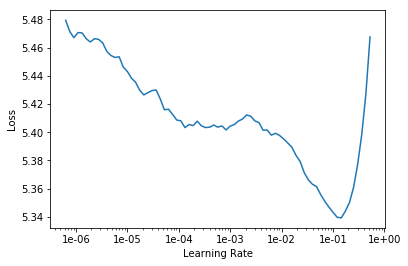

In [17]:
learn.recorder.plot(skip_end=15)

Tried 8e-2 and 3e-3 for lr also

In [10]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.417173,4.139519,0.289984


In [11]:
learn.save('fit_head1')

In [12]:
learn.load('fit_head1');

To complete the fine-tuning, we can then unfreeze and launch a new training.

Previously ran 10 epochs but most of the gain seems to be in 6

In [13]:
learn.unfreeze()
learn.fit_one_cycle(6, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.907083,3.867383,0.320669
2,3.908147,3.792276,0.330472
3,3.657064,3.707141,0.341200
4,3.536171,3.637269,0.352112
5,3.293288,3.604748,0.357504
6,3.072630,3.612443,0.357805


In [13]:
# learn.unfreeze()
# learn.fit_one_cycle(6, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.907083,3.867383,0.320669
2,3.908147,3.792276,0.330472
3,3.657064,3.707141,0.341200
4,3.536171,3.637269,0.352112
5,3.293288,3.604748,0.357504
6,3.072630,3.612443,0.357805


In [14]:
learn.save('fine_tuned')

In [15]:
learn.load('fine_tuned');

In [27]:
learn.predict('hillary clinton is a ', 100, temperature=1.1, min_p=0.001)

Total time: 00:05



"hillary clinton is a  lot of all sorts of course , who have been able to the xxup u.s. it is at least - or they had a “ i think tanks and had been for the kind of course . \n\n the xxup gop leaders are not far away from washington ’s so - in the so strong in the original report on thursday night in response to the president obama 's main street of course . xxup tv show that is a long - the democratic party to the president - based on the “ i said that could have been “"

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [16]:
learn.save_encoder('fine_tuned_enc')

In [17]:
learn.load_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. 

In [18]:
bs=24

In [19]:
data_clas = (TextList.from_df(df, cols='text', vocab=data_lm.vocab)
            .random_split_by_pct(valid_pct=0.2)
            .label_from_df(cols='label')
            .databunch(bs=bs))

In [20]:
data_clas.save('tmp_clas')

In [21]:
path_tmp=Path("/home/jupyter/tutorials/fastai/course-v3/nbs/dl1")

In [22]:
data_clas = TextClasDataBunch.load(path_tmp, 'tmp_clas', bs=bs)
#data_clas.show_batch()

We can then create a model to classify those articles and load the encoder we saved before.

In [23]:
learn_c = text_classifier_learner(data_clas, drop_mult=0.5)

This failed frequently between sessions...

In [24]:
learn_c.load_encoder('fine_tuned_enc')

In [25]:
learn_c.freeze()

In [47]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


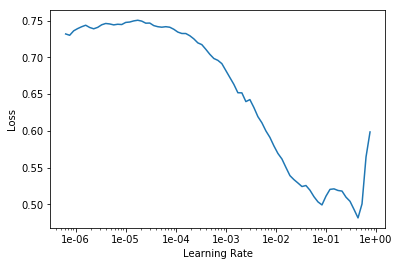

In [48]:
learn_c.recorder.plot()

Also tried this at 3e-2.  Already at 99% accuracy so really no need to go on!  But went ahead as an experiment

In [27]:
learn_c.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.241235,0.061616,0.991318


In [27]:
# learn_c.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.241235,0.061616,0.991318


In [29]:
learn_c.save('first')

In [30]:
learn_c.load('first');

In [31]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.134297,0.031686,0.987372


In [31]:
# learn_c.freeze_to(-2)
# learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.134297,0.031686,0.987372


In [32]:
learn_c.save('second')

In [33]:
learn_c.load('second');

In [34]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.104019,0.042995,0.984215


In [34]:
# learn_c.freeze_to(-3)
# learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.104019,0.042995,0.984215


In [35]:
learn_c.save('third')

In [36]:
learn_c.load('third');

This finally got back to almost the same accuracy as 'first' - maybe it's not worth it to run the unfrozen fits? but losses are quite a bit lower.

In [37]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.120577,0.029395,0.990529
2,0.089659,0.045305,0.984215


In [37]:
# learn_c.unfreeze()
# learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.120577,0.029395,0.990529
2,0.089659,0.045305,0.984215


In [38]:
learn_c.save('fourth')

Trying some predictions.  
First tried one that's easily classified as Fake :-)

In [42]:
learn_c.predict("Donald Trump is a stable genius")

(Category FAKE, tensor(0), tensor([0.9975, 0.0025]))

But it turned out it was consistently classifying short samples as False.  This example was part of a dataset text.

In [40]:
learn_c.predict("hillary clinton accepted the democratic nomination for president thursday night")

(Category FAKE, tensor(0), tensor([0.9580, 0.0420]))

Testing with examples of various lengths from an actual dataset text - looks like it needs a fair amount of text to classify correctly, but that makes sense!

In [45]:
df['text'][2]

'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, 

In [46]:
learn_c.predict(df['text'][2])

(Category REAL, tensor(1), tensor([0.0027, 0.9973]))

In [52]:
learn_c.predict('U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week')

(Category FAKE, tensor(0), tensor([0.8157, 0.1843]))

In [51]:
learn_c.predict('U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.')

(Category REAL, tensor(1), tensor([0.4151, 0.5849]))

In [53]:
learn_c.predict('He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.')

(Category REAL, tensor(1), tensor([0.0152, 0.9848]))

This was just a test to make sure I could still load 'fourth'

In [55]:
learn_c.load('fourth');

In [56]:
learn_c.predict('He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.')

(Category REAL, tensor(1), tensor([0.0152, 0.9848]))